In [2]:
#!/usr/bin/env python

# BFD_exceedances_analyses.ipynb

In [3]:
'''
    File name: BFD_exceedances_analyses.ipynb
    Author: Andreas Prein
    E-mail: prein@ucar.edu
    Date created: 04.07.2024
    Date last modified: 04.07.2024

    ############################################################## 
    Purpose:

    This program reads in data that was pre-processed by:
    papers/2024/2024_WBGT_Climate-Change/programs/BFD_exceedances/BFD_exceedances_analyses.ipynb
    
'''

'\n    File name: BFD_exceedances_analyses.ipynb\n    Author: Andreas Prein\n    E-mail: prein@ucar.edu\n    Date created: 04.07.2024\n    Date last modified: 04.07.2024\n\n    ############################################################## \n    Purpose:\n\n    This program reads in data that was pre-processed by:\n    papers/2024/2024_WBGT_Climate-Change/programs/BFD_exceedances/BFD_exceedances_analyses.ipynb\n    \n'

In [4]:
from dateutil import rrule
import datetime
import glob
from netCDF4 import Dataset
import sys, traceback
import dateutil.parser as dparser
import string
from pdb import set_trace as stop
import numpy as np
import numpy.ma as ma
import os
# import pickle
import subprocess
import pandas as pd
from scipy import stats
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import pylab as plt
import random
import scipy.ndimage as ndimage
import scipy
import shapefile
import matplotlib.path as mplPath
from matplotlib.patches import Polygon as Polygon2
# Cluster specific modules
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.vq import kmeans2,vq, whiten
from scipy.ndimage import gaussian_filter
import seaborn as sns
# import metpy.calc as mpcalc
import shapefile as shp
import sys
from scipy.signal import wiener, filtfilt, butter, gaussian, freqz
from scipy.ndimage import filters
import pickle
import time
import xarray as xr
from tqdm import tqdm
import matplotlib.gridspec as gridspec

In [5]:
datasets = ['ERA5', 'CONUS404_ctr', 'CONUS404_pgw']

flag_thresholds = [29, 31, 32]

data_dir = '/glade/campaign/mmm/c3we/prein/Papers/2024/2024_WBGT-climate-change/Flag_Exceedances/'

time_c404_ctr = pd.date_range(datetime.datetime(1980, 1, 1, 0), 
                              end=datetime.datetime(2020, 12, 31, 23), freq='h')
years_ctr = np.unique(time_c404_ctr.year)
time_c404_pgw = pd.date_range(datetime.datetime(1980, 1, 1, 0), 
                              end=datetime.datetime(2020, 12, 31, 23), freq='h')
years_pgw = np.unique(time_c404_pgw.year)
time_era5 = pd.date_range(datetime.datetime(1950, 1, 1, 0), 
                              end=datetime.datetime(2019, 12, 31, 23), freq='h')
era_years = np.unique(time_era5.year)

### Load the observed historic annual global temperature record

In [6]:
data = pd.read_csv('/glade/u/home/prein/papers/2024/2024_WBGT_Climate-Change/data/NASA_global-av_t2m/graph.txt', delimiter=r"\s+", header=0, skiprows=[0,1,2,4])

### LOAD GLOBAL AVERAGE T2M FROM LENS
##### this data was processed by Ming Ge

In [7]:
StartDay = datetime.datetime(1850, 1, 15,1)
StopDay = datetime.datetime(2101, 1, 15,0)
Time=pd.date_range(StartDay, end=StopDay, freq='M')
Time_years=pd.date_range(StartDay, end=StopDay, freq='Y')
years = np.unique(Time.year)

reference_period = [1950, 1980]

/glade/derecho/scratch/prein/tmp/ipykernel_25214/182532327.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  Time=pd.date_range(StartDay, end=StopDay, freq='M')
/glade/derecho/scratch/prein/tmp/ipykernel_25214/182532327.py:4: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  Time_years=pd.date_range(StartDay, end=StopDay, freq='Y')


In [8]:
lens2_t2m_dir = '/glade/campaign/mmm/c3we/mingge/DOD/LENS2/'
ncid=Dataset(lens2_t2m_dir + 'TREFMNAV_monthly_globalAvg_185001-197912.nc', mode='r')
TREFMNAV_hist = np.array(np.squeeze(ncid.variables['TREFMNAV'][:]))
ncid.close()
ncid=Dataset(lens2_t2m_dir + 'TREFMNAV_monthly_globalAvg_198001-201412.nc', mode='r')
TREFMNAV_cur = np.array(np.squeeze(ncid.variables['TREFMNAV'][:]))
ncid.close()
ncid=Dataset(lens2_t2m_dir + 'TREFMNAV_monthly_globalAvg_201501-210012.nc', mode='r')
TREFMNAV_fut = np.array(np.squeeze(ncid.variables['TREFMNAV'][:]))
ncid.close()

ncid=Dataset(lens2_t2m_dir + 'TREFMXAV_monthly_globalAvg_185001-197912.nc', mode='r')
TREFMXAV_hist = np.array(np.squeeze(ncid.variables['TREFMXAV'][:]))
ncid.close()
ncid=Dataset(lens2_t2m_dir + 'TREFMXAV_monthly_globalAvg_198001-201412.nc', mode='r')
TREFMXAV_cur = np.array(np.squeeze(ncid.variables['TREFMXAV'][:]))
ncid.close()
ncid=Dataset(lens2_t2m_dir + 'TREFMXAV_monthly_globalAvg_201501-210012.nc', mode='r')
TREFMXAV_fut = np.array(np.squeeze(ncid.variables['TREFMXAV'][:]))
ncid.close()

In [9]:
TREFMNAV = np.append(TREFMNAV_hist, TREFMNAV_cur, axis=1)
TREFMNAV = np.append(TREFMNAV, TREFMNAV_fut, axis=1)
TREFMXAV = np.append(TREFMXAV_hist, TREFMXAV_cur, axis=1)
TREFMXAV = np.append(TREFMXAV, TREFMXAV_fut, axis=1)
lens2_t2m = (TREFMNAV + TREFMXAV) / 2.

lens2_t2m_y = np.mean(np.reshape(lens2_t2m, (lens2_t2m.shape[0], int(lens2_t2m.shape[1]/12), 12)), axis=2)

ref_t2m = np.mean(lens2_t2m_y[:,(years >= reference_period[0]) & (years <= reference_period[1])])
time_to_t2m = np.mean(lens2_t2m_y, axis=0) - ref_t2m

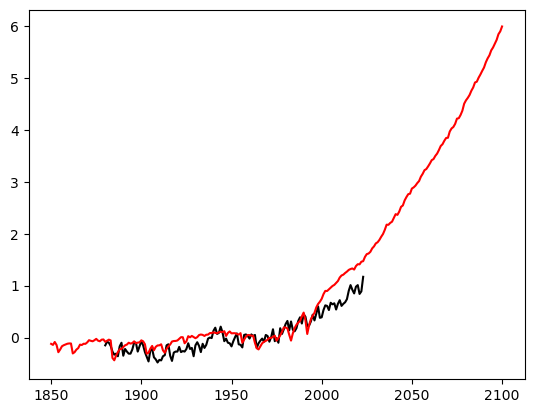

In [10]:
plt.plot(data['Year'], data['No_Smoothing'], c='k', label='NASA')
plt.plot(years, time_to_t2m, c='r', label='LENS2')

In [11]:
dc_hist = np.arange(0,1.5,0.1)
dc_pgw = np.arange(0,3.5,0.1)
dc = 0.5 # deg. C

ref_period = [1950,1979]

era5_ref = np.mean(data['No_Smoothing'][(data['Year'] >= ref_period[0]) & (data['Year'] <= ref_period[1])])
era5_warming = np.squeeze(np.array([data['No_Smoothing'][data['Year'] == yy] - era5_ref for yy in range(1980,2023,1)]))

lens2_ref = np.mean(time_to_t2m[(years >= ref_period[0]) & (years <= ref_period[1])])
lens2_warming = np.array([time_to_t2m[years == yy][0] - lens2_ref for yy in range(2022,2022+len(np.unique(time_c404_pgw.year)),1)])


pgw_warming = np.zeros((len(years_ctr))); pgw_warming[:] = np.nan
for yy in range(len(years_ctr)):
    lens_hist = (years <= years_ctr[yy] + 5) & (years >= years_ctr[yy] - 5)
    lens_fut = (years <= years_ctr[yy] + 40 + 5) & (years >= years_ctr[yy] + 40 - 5)
    pgw_warming[yy] = data['No_Smoothing'][years_ctr[yy] == data['Year']] + np.mean(time_to_t2m[lens_fut]) - np.mean(time_to_t2m[lens_hist])

/glade/derecho/scratch/prein/tmp/ipykernel_25214/2108212070.py:18: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pgw_warming[yy] = data['No_Smoothing'][years_ctr[yy] == data['Year']] + np.mean(time_to_t2m[lens_fut]) - np.mean(time_to_t2m[lens_hist])


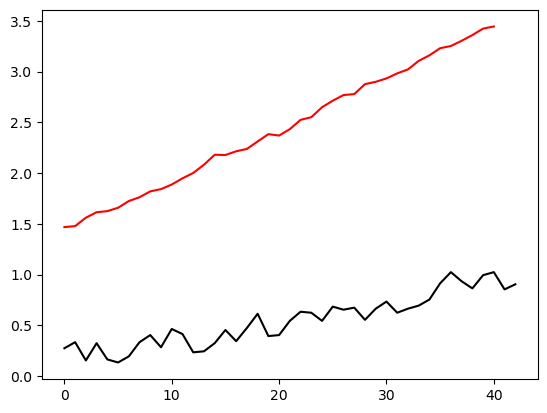

In [12]:
plt.plot(era5_warming, c='k')
plt.plot(lens2_warming, c='r')
# plt.plot(, c='b')

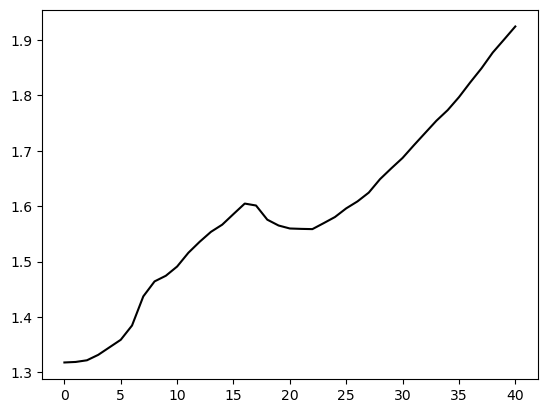

In [13]:
plt.plot(pgw_warming - era5_warming[:len(pgw_warming)], c='k')


### Load ERA5 data

In [14]:
yaers_e5 = np.unique(time_era5.year)
conus_era5 = [100,1250,270,900]

# read ERA5 coordinates
data = np.load(data_dir + '/1996_ERA5_flag_day_frequency.npz')
lon_e5 = data['lon']
lat_e5 = data['lat']
exceedances_e5 = data['exceedances']

lon_e5_2d, lat_e5_2d = np.meshgrid(lon_e5-360, lat_e5)

# era5_freq = np.zeros((list([len(yaers_e5)]) + list(exceedances_e5.shape))); era5_freq[:] = np.nan
# for yy in tqdm(range(len(yaers_e5))):
#     data = np.load(data_dir + '/'+str(yaers_e5[yy])+'_ERA5_flag_day_frequency.npz')
#     era5_freq[yy,:] = data['exceedances']

### create mask file for sub-regional analysis

In [15]:
import geopandas as gpd
MaskFile = '/glade/campaign/mmm/c3we/prein/Papers/2024/2024_WBGT-climate-change/ERA5_NCA_regions.npz'
if os.path.exists(MaskFile) == False:
    data = gpd.read_file('/glade/u/home/prein/ShapeFiles/NCA_regions/4th_ClimAssRegions.shp')
    # change CRS to epsg 4326
    Shapes = data.to_crs(epsg=4326)
    data = Shapes
    Coordinates = data['geometry']
    rgrGridCells=[(lon_e5_2d.flatten()[ii],lat_e5_2d.flatten()[ii]) for ii in range(len(lon_e5_2d.flatten()))]
    MaskStations = np.zeros((lat_e5.shape[0],lon_e5.shape[0])); MaskStations[:] = np.nan
    for sf in tqdm(range(len(data))):
        # TEST = np.array(Coordinates[sf].geoms.exterior.coords.xy)
        # TEST = np.array([list(xx[0].exterior.coords.xy) for xx in Coordinates[sf].geoms[0]])
        try:
            xx = Coordinates[sf].geoms
            if sf == 4:
                TEST = np.array(xx[2].exterior.coords)
            else:
                TEST = np.array(xx[0].exterior.coords)
            ctr=TEST
        except:
            TEST = np.array(Coordinates[sf].exterior.coords.xy)
            ctr=TEST.T
        grPRregion=mplPath.Path(ctr)
        TMP=np.array(grPRregion.contains_points(rgrGridCells))
        TMP = np.reshape(TMP, (lat_e5_2d.shape[0], lat_e5_2d.shape[1]))
        MaskStations[TMP==1] = sf+1        
        
    np.savez(MaskFile,
            MaskStations = MaskStations,
            lon_e5_2d = lon_e5_2d,
            lat_e5_2d = lat_e5_2d)
else:
    DATA = np.load(MaskFile)
    MaskStations = DATA['MaskStations']
    lon_e5_2d = DATA['lon_e5_2d']
    lat_e5_2d = DATA['lat_e5_2d']
MaskStations[MaskStations < 0] = 0

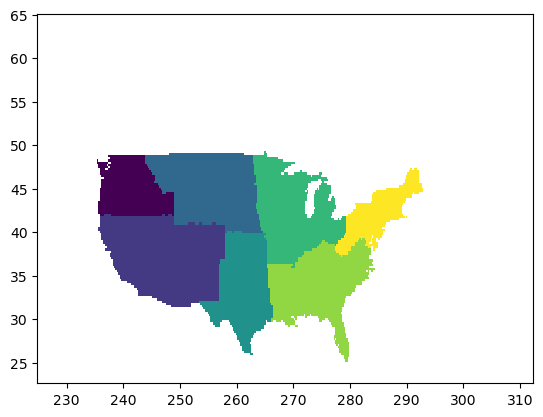

In [16]:
plt.pcolormesh(lon_e5, lat_e5, MaskStations)

### Calculate blag flag hours for months and hours

In [17]:
# monthly_freq_e5 = np.array([np.mean(np.sum(era5_freq[:,:,:,:,MaskStations == ii+1], axis=2), axis = (3)) for ii in range(7)])
# hourly_freq_e5 = np.array([np.mean(np.sum(era5_freq[:,:,:,:,MaskStations == ii+1], axis=1), axis = (3)) for ii in range(7)])

# Load CONUS404 ctr

In [18]:
## read CONUS coordinates
#data = np.load(data_dir + '/1993_CONUS404_ctr_flag_day_frequency.npz')
#lon_conus = data['lon']
#lat_conus = data['lat']
#exceedances_conus = data['exceedances']

#ctr_freq = np.zeros((list([len(years_ctr)]) + list(exceedances_conus.shape))); ctr_freq[:] = np.nan
#for yy in tqdm(range(len(years_ctr))):
#    data = np.load(data_dir + str(years_ctr[yy])+'_CONUS404_ctr_flag_day_frequency.npz')
#    ctr_freq[yy,:] = data['exceedances']

In [19]:
import geopandas as gpd
MaskFile = '/glade/campaign/mmm/c3we/prein/Papers/2024/2024_WBGT-climate-change/CONUS404_NCA_regions.npz'
if os.path.exists(MaskFile) == False:
    data = gpd.read_file('/glade/u/home/prein/ShapeFiles/NCA_regions/4th_ClimAssRegions.shp')
    # change CRS to epsg 4326
    Shapes = data.to_crs(epsg=4326)
    data = Shapes
    Coordinates = data['geometry']
    rgrGridCells=[(lon_conus.flatten()[ii],lat_conus.flatten()[ii]) for ii in range(len(lon_conus.flatten()))]
    MaskStations_conus = np.zeros((lon_conus.shape[0],lon_conus.shape[1])); MaskStations[:] = np.nan
    for sf in tqdm(range(len(data))):
        # TEST = np.array(Coordinates[sf].geoms.exterior.coords.xy)
        # TEST = np.array([list(xx[0].exterior.coords.xy) for xx in Coordinates[sf].geoms[0]])
        try:
            xx = Coordinates[sf].geoms
            if sf == 4:
                TEST = np.array(xx[2].exterior.coords)
            else:
                TEST = np.array(xx[0].exterior.coords)
            ctr=TEST
        except:
            TEST = np.array(Coordinates[sf].exterior.coords.xy)
            ctr=TEST.T
        grPRregion=mplPath.Path(ctr)
        TMP=np.array(grPRregion.contains_points(rgrGridCells))
        TMP = np.reshape(TMP, (lat_conus.shape[0], lat_conus.shape[1]))
        MaskStations_conus[TMP==1] = sf+1        
        
    np.savez(MaskFile,
            MaskStations_conus = MaskStations_conus,
            lon_conus = lon_conus,
            lat_conus = lat_conus)
else:
    DATA = np.load(MaskFile)
    MaskStations_conus = DATA['MaskStations_conus']
    lon_conus = DATA['lon_conus']
    lat_conus = DATA['lat_conus']
MaskStations_conus[MaskStations_conus < 0] = 0

In [20]:
#monthly_freq_ctr = np.array([np.mean(np.sum(ctr_freq[:,:,:,:,MaskStations_conus == ii+1], axis=2), axis = (3)) for ii in range(7)])
#hourly_freq_ctr = np.array([np.mean(np.sum(ctr_freq[:,:,:,:,MaskStations_conus == ii+1], axis=1), axis = (3)) for ii in range(7)])

In [21]:
#pgw_freq = np.zeros((list([len(years_pgw)]) + list(exceedances_conus.shape))); pgw_freq[:] = np.nan
#for yy in tqdm(range(len(years_pgw))):
#    data = np.load(data_dir + str(years_pgw[yy])+'_CONUS404_pgw_flag_day_frequency.npz')
#    pgw_freq[yy,:] = data['exceedances']

In [22]:
#monthly_freq_pgw = np.array([np.mean(np.sum(pgw_freq[:,:,:,:,MaskStations_conus == ii+1], axis=2), axis = (3)) for ii in range(7)])
#hourly_freq_pgw = np.array([np.mean(np.sum(pgw_freq[:,:,:,:,MaskStations_conus == ii+1], axis=1), axis = (3)) for ii in range(7)])

### calculate summs over hours and months

In [23]:
#ctr_freq_yearsum = np.sum(ctr_freq, axis = (1,2))
#pgw_freq_yearsum = np.sum(pgw_freq, axis = (1,2))
#era5_freq_yearsum = np.sum(era5_freq, axis = (1,2))

In [24]:
"""
np.savez(data_dir + '/annual_flag_day_frequency.npz',
                         lon_conus = lon_conus,
                         lat_conus = lat_conus,
                         lon_e5 = lon_e5,
                         lat_e5 = lat_e5,
                         flag_thresholds = flag_thresholds,
                          ctr_freq_yearsum = ctr_freq_yearsum,
                          pgw_freq_yearsum = pgw_freq_yearsum,
                          era5_freq_yearsum = era5_freq_yearsum,
                          monthly_freq_e5 = monthly_freq_e5,
                          hourly_freq_e5 = hourly_freq_e5,
                          monthly_freq_ctr = monthly_freq_ctr,
                          hourly_freq_ctr = hourly_freq_ctr,
                          monthly_freq_pgw = monthly_freq_pgw,
                          hourly_freq_pgw = hourly_freq_pgw
                         )
"""

"\nnp.savez(data_dir + '/annual_flag_day_frequency.npz',\n                         lon_conus = lon_conus,\n                         lat_conus = lat_conus,\n                         lon_e5 = lon_e5,\n                         lat_e5 = lat_e5,\n                         flag_thresholds = flag_thresholds,\n                          ctr_freq_yearsum = ctr_freq_yearsum,\n                          pgw_freq_yearsum = pgw_freq_yearsum,\n                          era5_freq_yearsum = era5_freq_yearsum,\n                          monthly_freq_e5 = monthly_freq_e5,\n                          hourly_freq_e5 = hourly_freq_e5,\n                          monthly_freq_ctr = monthly_freq_ctr,\n                          hourly_freq_ctr = hourly_freq_ctr,\n                          monthly_freq_pgw = monthly_freq_pgw,\n                          hourly_freq_pgw = hourly_freq_pgw\n                         )\n"

In [25]:
data = np.load(data_dir + '/annual_flag_day_frequency.npz')
flag_thresholds = data['flag_thresholds']
ctr_freq_yearsum = data['ctr_freq_yearsum']
pgw_freq_yearsum = data['pgw_freq_yearsum']
era5_freq_yearsum = data['era5_freq_yearsum']
monthly_freq_e5 = data['monthly_freq_e5']
hourly_freq_e5 = data['hourly_freq_e5']
monthly_freq_ctr = data['monthly_freq_ctr']
hourly_freq_ctr = data['hourly_freq_ctr']
monthly_freq_pgw = data['monthly_freq_pgw']
hourly_freq_pgw = data['hourly_freq_pgw']

### Plot exceedance frequency and their changes for different warming levels

In [26]:
from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
import cartopy.feature as cf
import cartopy.crs as ccrs
GEO_EM_D1 = '/glade/u/home/prein/projects/2020/2020_CONUS404/data/wrfconstants_d01_CONUS404.nc4'
ncfile = Dataset(GEO_EM_D1)
HGT_M = getvar(ncfile, "HGT")
LU = getvar(ncfile, "LU_INDEX")
cart_proj = get_cartopy(HGT_M)
ncid.close()

In [27]:
from matplotlib import colors as c
### map for exceedances
wbgt_colros = ['#ffffff','#e0ecf4','#bfd3e6','#9ebcda','#8c96c6','#8c6bb1','#88419d','#810f7c','#4d004b']
ticks_color_exc = [0, 1, 5,10,20,40,80,160, 320]
cMap_exc = c.ListedColormap(wbgt_colros)

### map for changes
wbgt_change = ['#deebf7','#ffffff','#efe49c', '#eec068','#e87e31','#d4662e','#cf342b','#9f2027','#56140e','#821763','#992ba8','#d33ef0','#ec87f5']
ticks_color_ch = (np.array([-10, -2, 2, 5, 10, 20, 40, 90, 140, 200, 300, 400, 500])/2).astype(int)
cMap_cha = c.ListedColormap(wbgt_change)

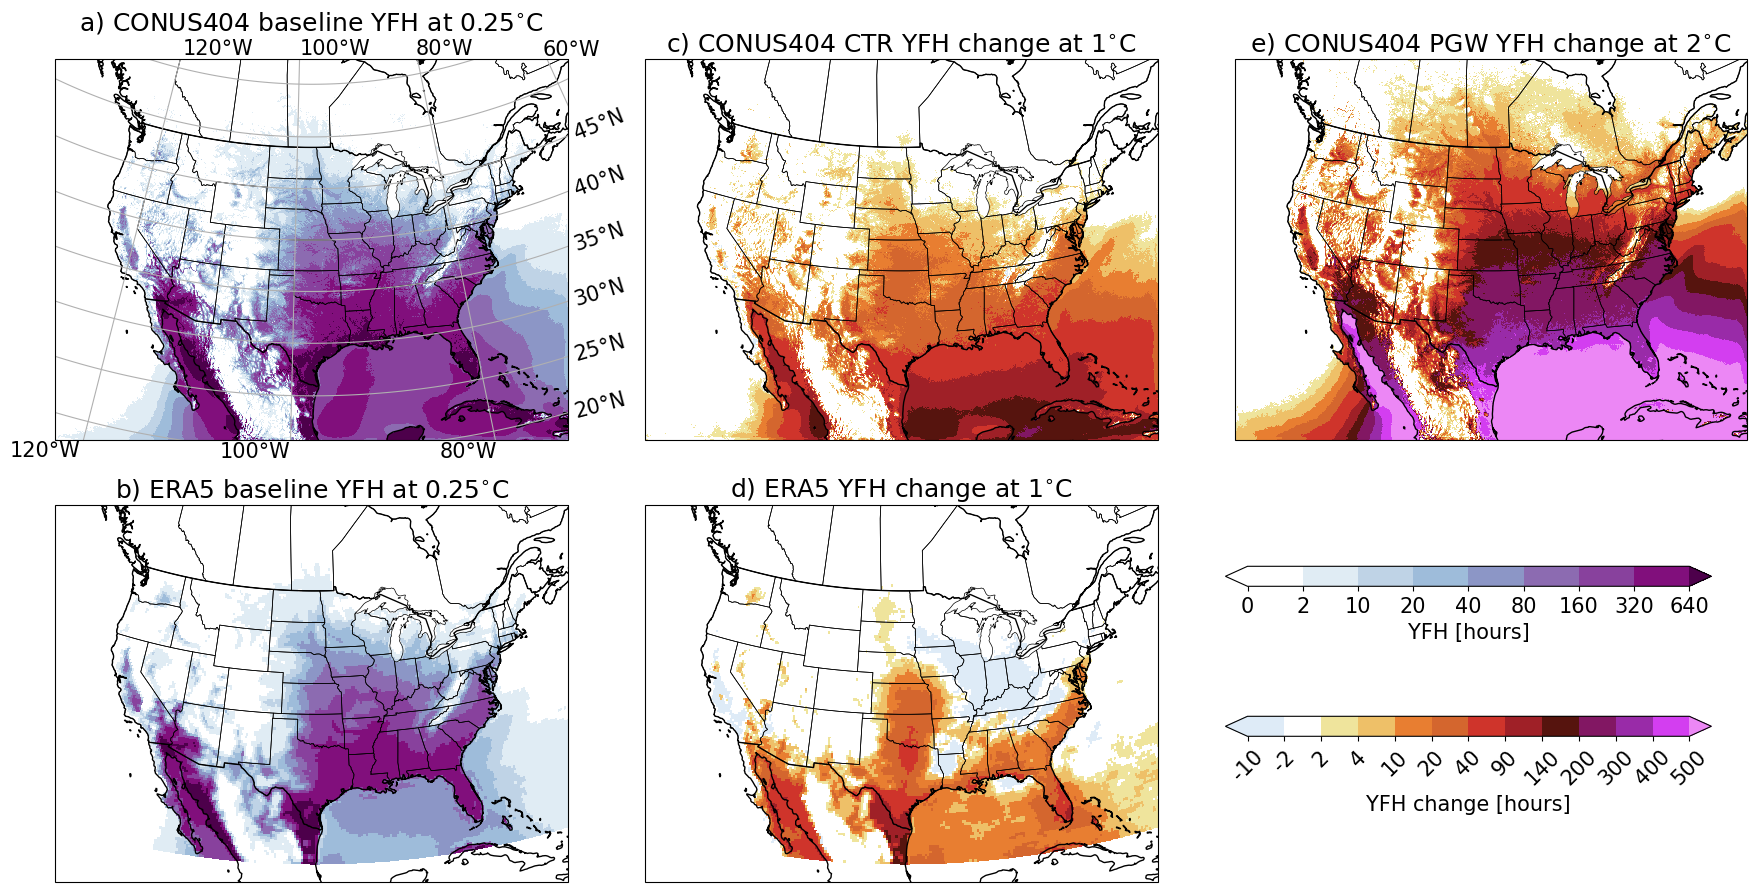

In [41]:
fig = plt.figure(figsize=(18,10))
plt.rcParams.update({'font.size': 15})
gs1 = gridspec.GridSpec(2,3)
gs1.update(left=0.05, right=0.99,
           bottom=0.10, top=0.93,
           wspace=0.15, hspace=0.15)

foc_region = ' '
# foc_region = ' ', 'Yuma'
warn_lev = 0 # yellow flag = 0, red flag = 1; black flag = 2 
warn_lev_names = ["YFH","RFH","BFH"]
scale_fac = [2,1,1]

# =========================
# 0.25 C warming
ax = plt.subplot(gs1[0,0], projection=cart_proj)
pos1 = ax.get_position()

warming_tar = 0.25
targ_years_ref = (era5_warming >= warming_tar - dc) & (era5_warming <= warming_tar + dc)
plt.title("a) CONUS404 baseline "+warn_lev_names[warn_lev]+" at "+str(warming_tar)+'$^{\circ}$C')
cs = ax.pcolormesh(lon_conus, lat_conus, np.nanmean(ctr_freq_yearsum[targ_years_ref[:-2],warn_lev], axis=0), 
                   transform=ccrs.PlateCarree(),
                   cmap = cMap_exc,
                   norm = mpl.colors.BoundaryNorm(np.array(ticks_color_exc) * scale_fac[warn_lev], ncolors=len(ticks_color_exc)-1, clip=False))

ax.coastlines()
ax.add_feature(cf.BORDERS)
ax.add_feature(cf.STATES, lw=0.5)
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.xlabel_style = {'rotation': 0}
gl.left_labels = False
if foc_region == 'Yuma':
    ax.set_extent((-116, -110, 32, 35), ccrs.PlateCarree())
elif foc_region == 'Northwest':
    ax.set_extent((-130, -110, 46, 51), ccrs.PlateCarree())

# =========================
# 0.25 C warming ERA5
ax = plt.subplot(gs1[1,0], projection=cart_proj)
pos1 = ax.get_position()

warming_tar = 0.25
targ_years_ref = (era5_warming >= warming_tar - dc) & (era5_warming <= warming_tar + dc)
plt.title("b) ERA5 baseline "+warn_lev_names[warn_lev]+" at "+str(warming_tar)+'$^{\circ}$C')

cs = ax.pcolormesh(lon_e5, lat_e5, np.nanmean(era5_freq_yearsum[np.isin(era_years, years_ctr),warn_lev,:][targ_years_ref[:-3],:], axis=0), 
                   transform=ccrs.PlateCarree(),
                   cmap = cMap_exc,
                   norm = mpl.colors.BoundaryNorm(np.array(ticks_color_exc) * scale_fac[warn_lev], ncolors=len(ticks_color_exc)-1, clip=False))

ax.coastlines()
ax.add_feature(cf.BORDERS)
ax.add_feature(cf.STATES, lw=0.5)
ax.set_extent((-124, -72.5, 21, 55), ccrs.PlateCarree())
if foc_region == 'Yuma':
    ax.set_extent((-116, -110, 32, 35), ccrs.PlateCarree())
elif foc_region == 'Northwest':
    ax.set_extent((-130, -110, 46, 51), ccrs.PlateCarree())

# Add a color bar
CbarAx = plt.axes([0.7, 0.4, 0.27, 0.02])
cb = plt.colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both')#, ticks=np.linspace(0,0.0015,41))
cb.set_label(warn_lev_names[warn_lev]+" [hours]", fontsize=15)
cb.set_ticks(np.array(ticks_color_exc) * scale_fac[warn_lev])
cb.set_ticklabels(np.array(ticks_color_exc) * scale_fac[warn_lev])



# =========================
# 1 C warming change
ax = plt.subplot(gs1[0,1], projection=cart_proj)
pos1 = ax.get_position()

warming_tar = 1
targ_years = (era5_warming >= warming_tar - dc) & (era5_warming <= warming_tar + dc)
plt.title("c) CONUS404 CTR "+warn_lev_names[warn_lev]+" change at "+str(warming_tar)+'$^{\circ}$C')

cs = ax.pcolormesh(lon_conus, lat_conus, 
                   np.nanmean(ctr_freq_yearsum[targ_years[:-2],warn_lev], axis=0) -
                   np.nanmean(ctr_freq_yearsum[targ_years_ref[:-2],warn_lev], axis=0), 
                   transform=ccrs.PlateCarree(),
                   cmap = cMap_cha,
                   norm = mpl.colors.BoundaryNorm(np.array(ticks_color_ch) * scale_fac[warn_lev], ncolors=len(ticks_color_ch)-1, clip=False))

ax.coastlines()
ax.add_feature(cf.BORDERS)
ax.add_feature(cf.STATES, lw=0.5)
if foc_region == 'Yuma':
    ax.set_extent((-116, -110, 32, 35), ccrs.PlateCarree())
elif foc_region == 'Northwest':
    ax.set_extent((-130, -110, 46, 51), ccrs.PlateCarree())


# =========================
# 1 C warming change ERA5
ax = plt.subplot(gs1[1,1], projection=cart_proj)
pos1 = ax.get_position()

warming_tar = 1
targ_years = (era5_warming >= warming_tar - dc) & (era5_warming <= warming_tar + dc)
plt.title("d) ERA5 "+warn_lev_names[warn_lev]+" change at "+str(warming_tar)+'$^{\circ}$C')

cs = ax.pcolormesh(lon_e5, lat_e5, 
                   np.nanmean(era5_freq_yearsum[np.isin(era_years, years_ctr),warn_lev,:][targ_years[:-3],:], axis=0) -
                   np.nanmean(era5_freq_yearsum[np.isin(era_years, years_ctr),warn_lev,:][targ_years_ref[:-3],:], axis=0), 
                   transform=ccrs.PlateCarree(),
                   cmap = cMap_cha,
                   norm = mpl.colors.BoundaryNorm(np.array(ticks_color_ch) * scale_fac[warn_lev], ncolors=len(ticks_color_ch)-1, clip=False))

ax.coastlines()
ax.add_feature(cf.BORDERS)
ax.add_feature(cf.STATES, lw=0.5)
ax.set_extent((-124, -72.5, 21, 55), ccrs.PlateCarree())
if foc_region == 'Yuma':
    ax.set_extent((-116, -110, 32, 35), ccrs.PlateCarree())
elif foc_region == 'Northwest':
    ax.set_extent((-130, -110, 46, 51), ccrs.PlateCarree())

# Add a color bar
CbarAx = plt.axes([0.7, 0.25, 0.27, 0.02])
cb = plt.colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both')#, ticks=np.linspace(0,0.0015,41))
cb.set_label(warn_lev_names[warn_lev]+" change [hours]", fontsize=15)
cb.set_ticks(np.array(ticks_color_ch) * scale_fac[warn_lev])
cb.set_ticklabels(np.array(ticks_color_ch) * scale_fac[warn_lev])
cb.ax.tick_params(labelrotation=45)

# =========================
# 2 C warming change
ax = plt.subplot(gs1[0,2], projection=cart_proj)
pos1 = ax.get_position()

warming_tar = 2
targ_years = (pgw_warming[:len(years_pgw)] >= warming_tar - dc) & (pgw_warming[:len(years_pgw)] <= warming_tar + dc)
plt.title("e) CONUS404 PGW "+warn_lev_names[warn_lev]+" change at "+str(warming_tar)+'$^{\circ}$C')

cs = ax.pcolormesh(lon_conus, lat_conus, 
                   np.nanmean(pgw_freq_yearsum[targ_years,warn_lev], axis=0) -
                   np.nanmean(ctr_freq_yearsum[targ_years_ref[:-2],warn_lev], axis=0), 
                   transform=ccrs.PlateCarree(),
                   cmap = cMap_cha,
                   norm = mpl.colors.BoundaryNorm(np.array(ticks_color_ch) * scale_fac[warn_lev], ncolors=len(ticks_color_ch)-1, clip=False))

ax.coastlines()
ax.add_feature(cf.BORDERS)
ax.add_feature(cf.STATES, lw=0.5)
if foc_region == 'Yuma':
    ax.set_extent((-116, -110, 32, 35), ccrs.PlateCarree())
elif foc_region == 'Northwest':
    ax.set_extent((-130, -110, 46, 51), ccrs.PlateCarree())


sPlotFile=""
"""
sPlotName= 'BFD_changes.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName) #, dpi=700)
"""
sPlotName= "Fig2_"+warn_lev_names[warn_lev]+"_changes.jpg"
fig.savefig(sPlotFile+sPlotName, dpi=700, bbox_inches='tight')


In [29]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points on the Earth's surface.

    Parameters:
        lat1, lon1: Latitude and Longitude of point 1 (in degrees)
        lat2, lon2: Latitude and Longitude of point 2 (in degrees)

    Returns:
        Distance in kilometers.
    """
    # Earth radius in kilometers
    R = 6371.0

    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c

def calculate_distance_grid(lat1, lon1, lat_grid, lon_grid):
    """
    Calculate the distance between a single point (lat1, lon1) and a grid of points.

    Parameters:
        lat1, lon1: Latitude and Longitude of the single point (in degrees)
        lat_grid, lon_grid: 2D arrays of Latitude and Longitude of the grid points (in degrees)

    Returns:
        2D array of distances in kilometers.
    """
    # Ensure the inputs are numpy arrays
    lat_grid = np.array(lat_grid)
    lon_grid = np.array(lon_grid)

    # Use broadcasting to calculate distances
    distances = haversine_distance(lat1, lon1, lat_grid, lon_grid)

    return distances


### Threshold exceedances in Cities

In [30]:
cities = ['Phoenix',
          'Miami',
          'New Orleans',
          'Houston',
          'Atlanta',
          'DC',
          # 'Yuma',
          'Sacramento'
          'Dalas',
          'Charlotte']
city_loc = [
            [[350,370],[370,390]],
            [[1120,1135],[170,225]],
            [[860,880],[255,265]],
            [[730,760],[240,270]],
            [[980,1000],[373,400]],
            [[1110,1135],[540,575]],
            # [[292,300],[365,370]],
            [[180,195],[550,570]],
            [[685,720],[325,350]],
            [[1055,1070],[430,450]]
           ]

temp_channge = np.arange(0,3.1,0.1)
delta_t = 0.25
minyears = 7

city_freq_change = np.zeros((len(temp_channge), len(cities),3)); city_freq_change[:] = np.nan
rural_freq_change = np.copy(city_freq_change)
city_time_series = np.zeros((len(Time), len(cities))); city_time_series[:] = np.nan

for cy in range(len(cities)):
    # use center of given indices and calculate radius for urban and non-urban grid cells
    lat_cent = int((city_loc[cy][1][0]+city_loc[cy][1][1])/2)
    lon_cent = int((city_loc[cy][0][0]+city_loc[cy][0][1])/2)
    dist = haversine_distance(lat_conus[lat_cent,lon_cent], lon_conus[lat_cent,lon_cent],
                     lat_conus, lon_conus)
    urban_cells = (dist <= 50) &  (LU == 13) 
    rural_cells = (dist <= 50) &  (LU != 13) & (LU != 17)
    
    # URBAN
    data_ctr = ctr_freq_yearsum[:,2,urban_cells]
    data_ctr = np.mean(data_ctr[:,:], axis = 1)
    data_pgw = pgw_freq_yearsum[:,2,urban_cells]
    data_pgw = np.mean(data_pgw[:,:], axis = 1)

    # RURAL
    data_ctr_rural = ctr_freq_yearsum[:,2,rural_cells]
    data_ctr_rural = np.mean(data_ctr_rural[:,:], axis = 1)
    data_pgw_rural = pgw_freq_yearsum[:,2,rural_cells]
    data_pgw_rural = np.mean(data_pgw_rural[:,:], axis = 1)

    for te in range(len(temp_channge)):
        years_sel = (era5_warming[:-2] >= temp_channge[te] - delta_t) & (era5_warming[:-2] <= temp_channge[te] + delta_t)
        if np.sum(years_sel) >= minyears:
            # city_freq_change[te,cy,0] = np.median(data_ctr[years_sel])
            city_freq_change[te,cy,:] = np.percentile(data_ctr[years_sel],(25,50,75))
            rural_freq_change[te,cy,:] = np.percentile(data_ctr_rural[years_sel],(25,50,75))
        years_sel = (pgw_warming >= temp_channge[te] - delta_t) & (pgw_warming <= temp_channge[te] + delta_t)
        if np.sum(years_sel[:len(data_pgw)]) >= minyears:
            # city_freq_change[te,cy,0] = np.median(data_pgw[years_sel[:len(data_pgw)]])
            city_freq_change[te,cy,:] = np.percentile(data_pgw[years_sel[:len(data_pgw)]],(25,50,75))
            rural_freq_change[te,cy,:] = np.percentile(data_pgw_rural[years_sel[:len(data_pgw_rural)]],(25,50,75))

In [31]:
# plt.plot(years_pgw+42,np.mean(pgw_freq_yearsum[:,2,city_loc[cy][1][0]:city_loc[cy][1][1], \
#                  city_loc[cy][0][0]:city_loc[cy][0][1]][:,city_gc], axis=1))

# plt.plot(years_ctr,np.mean(ctr_freq_yearsum[:,2,city_loc[cy][1][0]:city_loc[cy][1][1], \
#                  city_loc[cy][0][0]:city_loc[cy][0][1]][:,city_gc], axis=1))

### Plot black flag hour changes in cities

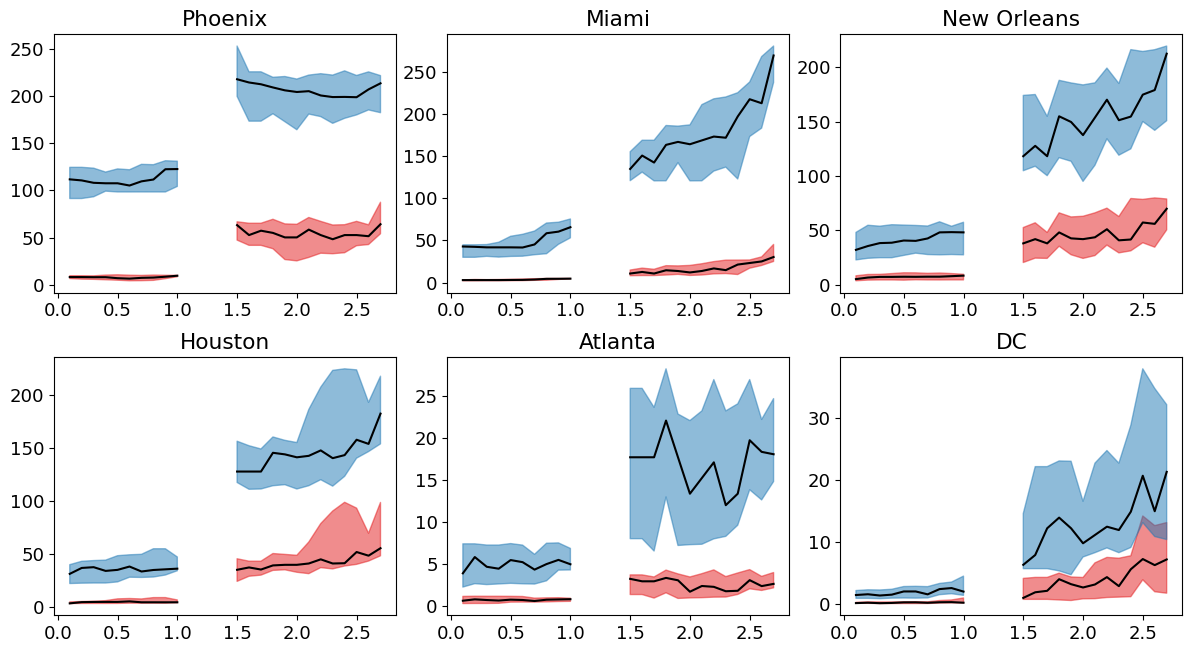

In [32]:
fig = plt.figure(figsize=(12,7))
plt.rcParams.update({'font.size': 13})
gs1 = gridspec.GridSpec(2,3)
gs1.update(left=0.05, right=0.99,
           bottom=0.10, top=0.93,
           wspace=0.15, hspace=0.25)

for xx in range(3):
    for yy in range(2):
        ax = plt.subplot(gs1[yy,xx])

        pos1 = ax.get_position()

        # urban
        plt.plot(temp_channge, city_freq_change[:,xx + yy*3,1], c='k')
        plt.fill_between(temp_channge, 
                         y1=city_freq_change[:,xx + yy*3,0], 
                         y2=city_freq_change[:,xx + yy*3,2], alpha=0.5, color="#e31a1c")

        # rural
        plt.plot(temp_channge, rural_freq_change[:,xx + yy*3,1], c='k')
        plt.fill_between(temp_channge, 
                         y1=rural_freq_change[:,xx + yy*3,0], 
                         y2=rural_freq_change[:,xx + yy*3,2], alpha=0.5, color="#1f78b4")
        plt.title(cities[xx + yy*3])
        # plt.plot(temp_channge, city_freq_change[:,0,1])
        
        # plt.plot(temp_channge, city_freq_change[:,1,0])
        # plt.plot(temp_channge, city_freq_change[:,2])
        # plt.plot(temp_channge, city_freq_change[:,3])
        # plt.plot(temp_channge, city_freq_change[:,4])
        # plt.plot(temp_channge, city_freq_change[:,5])

### Load and remapp population density

In [33]:
pop_file = '/glade/campaign/mmm/c3we/prein/Papers/2024/2024_WBGT-climate-change/NASA_population/gpw-v4-population-density-adjusted-to-2015-unwpp-country-totals-rev11_totpop_2pt5_min_nc/gpw_v4_population_density_adjusted_rev11_2pt5_min.nc'
data = xr.open_dataset(pop_file)
population = np.array(data[list(data.keys())[0]])
lon_pop = np.array(data["longitude"])
lat_pop = np.array(data["latitude"])

lon_pop, lat_pop = np.meshgrid(lon_pop, lat_pop)

/glade/u/home/prein/.local/lib/python3.10/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: Engine 'cfradial1' loading failed:
cannot import name 'HybridMappingProxy' from 'xarray.core.utils' (/glade/u/home/prein/.local/lib/python3.10/site-packages/xarray/core/utils.py)
  external_backend_entrypoints = backends_dict_from_pkg(entrypoints_unique)
/glade/u/home/prein/.local/lib/python3.10/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: Engine 'furuno' loading failed:
cannot import name 'HybridMappingProxy' from 'xarray.core.utils' (/glade/u/home/prein/.local/lib/python3.10/site-packages/xarray/core/utils.py)
  external_backend_entrypoints = backends_dict_from_pkg(entrypoints_unique)
/glade/u/home/prein/.local/lib/python3.10/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: Engine 'gamic' loading failed:
cannot import name 'HybridMappingProxy' from 'xarray.core.utils' (/glade/u/home/prein/.local/lib/python3.10/site-packages/xarray/core/utils.py)
  exte

KeyboardInterrupt: 

In [ ]:
if os.path.exists("/glade/campaign/mmm/c3we/prein/Papers/2024/2024_WBGT-climate-change/NASA_population/tar_grid.nc"):
    # Read the NetCDF file
    data = xr.open_dataset("/glade/campaign/mmm/c3we/prein/Papers/2024/2024_WBGT-climate-change/NASA_population/tar_grid.nc")
    print(data)

In [ ]:
from HelperFunctions import fnCDOregrid
dfDataDest = np.zeros((population.shape[0],lon_conus.shape[0],lon_conus.shape[1]))
DATA_TarGrid = fnCDOregrid(population,
                            lon_pop,
                            lat_pop,
                            dfDataDest,
                            lon_conus, 
                            lat_conus,
                            sRemapMeth='remapcon')

In [ ]:
plt.pcolormesh(lon_conus, lat_conus, DATA_TarGrid[4,:], vmin=0, vmax = 100)

In [ ]:
!pip install rioxarray

In [ ]:
import rioxarray

In [ ]:
tiff_file = '/glade/campaign/mmm/c3we/prein/Papers/2024/2024_WBGT-climate-change/lifestock/5_Ct_2010_Da.tif'
cattle_pop = rioxarray.open_rasterio(tiff_file)

In [ ]:
dx_cattle = 0.083333
lon_cattle = np.linspace(-180+dx_cattle/2, 180-dx_cattle/2, cattle_pop.shape[2])
lat_cattle = np.linspace(90-dx_cattle/2, -90+dx_cattle/2, cattle_pop.shape[1])
lon_cattle, lat_cattle = np.meshgrid(lon_cattle, lat_cattle)

In [ ]:
# normalize the density to km^2
sys.path.append('/glade/u/home/prein/MajorCodeDevelopments/Feature_Tracker/MOAAP')
from Tracking_Functions import calc_grid_distance_area
dx,dy,area,grid_distance = calc_grid_distance_area(lon_cattle,lat_cattle)
cattle_pop = cattle_pop / (area/1000**2)

In [ ]:
dfDataDest = np.zeros((cattle_pop.shape[0],lon_conus.shape[0],lon_conus.shape[1]))
cattle_TarGrid = fnCDOregrid(cattle_pop,
                            lon_cattle,
                            lat_cattle,
                            dfDataDest,
                            lon_conus, 
                            lat_conus,
                            sRemapMeth='remapcon')
cattle_TarGrid[cattle_TarGrid < 0] = np.nan

In [ ]:
plt.pcolormesh(lon_conus, lat_conus, cattle_TarGrid[0,:], vmin=0, vmax = 100)

### Calculate changes in population and cattle exposiour with increasing warming

In [ ]:
# calculate grid cell area for CONUS
dx,dy,area_conus,grid_distance = calc_grid_distance_area(lon_conus, lat_conus)

In [ ]:
cattle_conus = cattle_TarGrid[0,:] * (area_conus/(1000**2))
humans_connus = DATA_TarGrid[4,:] * (area_conus/(1000**2))

file_cattle_hum_exp = "/glade/campaign/mmm/c3we/prein/Papers/2024/2024_WBGT-climate-change/human-cattle-exposiour.npz"
if os.path.exists(file_cattle_hum_exp) == False:
    # multiply black flag hours by population density
    pop_hours_ctr = ctr_freq_yearsum[:,2,:,:] * humans_connus[None,:,:]
    pop_hours_pgw = pgw_freq_yearsum[:,2,:,:] * humans_connus[None,:,:]
    cattle_hours_ctr = ctr_freq_yearsum[:,2,:,:] * cattle_conus[None,:,:]
    cattle_hours_pgw = pgw_freq_yearsum[:,2,:,:] * cattle_conus[None,:,:]
    
    humans_exposiour = np.zeros((len(temp_channge),7,3)); humans_exposiour[:] = np.nan
    cattle_exposiour = np.copy(humans_exposiour)
    for te in tqdm(range(len(temp_channge))):
        for re in range(7):
            region_sel = re+1 == MaskStations_conus
            years_sel = (era5_warming[:-2] >= temp_channge[te] - delta_t) & (era5_warming[:-2] <= temp_channge[te] + delta_t)
            if np.sum(years_sel) >= minyears:
                humans_exposiour[te,re,:] = np.nansum(np.nanpercentile(pop_hours_ctr[years_sel][:,region_sel], (25,50,75), axis=0), axis = 1)
                # humans_exposiour[te,1] = np.nansum(np.nanstd(pop_hours_ctr[years_sel][:,region_sel], axis=0))
        
                cattle_exposiour[te,re,:] = np.nansum(np.nanpercentile(cattle_hours_ctr[years_sel][:,region_sel], (25,50,75), axis=0), axis = 1)
                # cattle_exposiour[te,1] = np.nansum(np.nanstd(cattle_hours_ctr[years_sel][:,region_sel], axis=0))
            years_sel = (pgw_warming >= temp_channge[te] - delta_t) & (pgw_warming <= temp_channge[te] + delta_t)
            if np.sum(years_sel[:len(data_pgw)]) >= minyears:
                humans_exposiour[te,re,:] = np.nansum(np.nanpercentile(pop_hours_pgw[years_sel[:len(data_pgw)]][:,region_sel], (25,50,75), axis=0), axis = 1)
                # humans_exposiour[te,1] = np.nansum(np.nanstd(pop_hours_pgw[years_sel[:len(data_pgw)]][:,region_sel], axis=0))
    
                cattle_exposiour[te,re,:] = np.nansum(np.nanpercentile(cattle_hours_pgw[years_sel[:len(data_pgw)]][:,region_sel], (25,50,75), axis=0), axis = 1)
                # cattle_exposiour[te,1] = np.nansum(np.nanstd(cattle_hours_pgw[years_sel[:len(data_pgw)]][:,region_sel], axis=0))
    
    np.savez(file_cattle_hum_exp,
            humans_exposiour = humans_exposiour,
            cattle_exposiour = cattle_exposiour,
            temp_channge = temp_channge,
            region_names = region_names)
else:
    data_exp = np.load(file_cattle_hum_exp)
    humans_exposiour = data_exp["humans_exposiour"]
    cattle_exposiour = data_exp["cattle_exposiour"]

In [ ]:
def func(x, a, b):
    return a * np.exp(b * x)

from scipy.optimize import curve_fit

# https://stackoverflow.com/questions/17458580/embedding-small-plots-inside-subplots-in-matplotlib
def add_subplot_axes(ax,rect):#,axisbg='w'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    #subax = fig.add_axes([x,y,width,height],facecolor=facecolor)  # matplotlib 2.0+
    subax = fig.add_axes([x,y,width,height])#,axisbg=axisbg)
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax

In [ ]:
fig = plt.figure(figsize=(16,7))
plt.rcParams.update({'font.size': 14})
gs1 = gridspec.GridSpec(2,4)
gs1.update(left=0.05, right=0.99,
           bottom=0.10, top=0.93,
           wspace=0.15, hspace=0.25)
rgsLableABC=list(string.ascii_lowercase)

region_names = ['Nortwest',
               'Southwest',
               'Northern Great Plains',
               'Southern Great Plains',
               'Midwest',
               'Southeast',
               'Northeast']

for xx in range(4):
    for yy in range(2):
        if yy*4+xx < 7:
            ax = plt.subplot(gs1[yy,xx])
    
            fin = ~np.isnan(humans_exposiour[:,yy*4+xx,1])
            plt.plot(temp_channge, humans_exposiour[:,yy*4+xx,1], c='w')
            plt.fill_between(temp_channge[:], 
                             y1=humans_exposiour[:,yy*4+xx,0], 
                             y2=humans_exposiour[:,yy*4+xx,2],
                            color='#1f78b4')
            if yy == 1:
                plt.xlabel('global warming level [$^{\circ}$C]')
            if (yy == 0) & (xx == 3):
                plt.xlabel('global warming level [$^{\circ}$C]')
            if xx == 0:
                plt.ylabel('BFH exposure of\ncapita per year\n[capita hours]')
            ax.spines[['right', 'top']].set_visible(False)
    
            popt, pcov = curve_fit(func, temp_channge[fin],  humans_exposiour[:,yy*4+xx,1][fin])
            residuals = humans_exposiour[:,yy*4+xx,1][fin] - func(temp_channge[fin], *popt)
            rrmse = np.sqrt(np.mean(residuals**2))/np.mean(humans_exposiour[:,yy*4+xx,1][fin])
            #plt.plot(temp_channge[fin], func(temp_channge[fin], * popt), 'k--',
            #     label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
            plt.plot(temp_channge[fin], func(temp_channge[fin], * popt), 'k--',
                 label="fit: a="+str((int(popt[0]/10**6)))+", b="+str((np.round(popt[1],2)))+";\nRRMSE="+str(np.round(rrmse,2)))
            plt.title(rgsLableABC[yy*4+xx]+') '+region_names[yy*4+xx])
            plt.legend(loc="upper left")
            ax.set_facecolor("none")
            
            # plot inlet
            ax_i = add_subplot_axes(ax, [0.05,0.45,0.3,0.3])
            ax_i.set_zorder(ax.get_zorder() - 1)
            region_hl = np.copy(MaskStations_conus)
            region_hl[MaskStations_conus != yy*4+xx+1] = np.nan
            ax_i.pcolormesh(region_hl, cmap='coolwarm_r')
            ax_i.contour(MaskStations_conus > 0, linewidths=0.75, colors='k')
            plt.axis('off')
            
            
sPlotFile=""
"""
sPlotName= 'pop-exposiour_subregions.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName, bbox_inches='tight') #, dpi=700)
"""
sPlotName= 'pop-exposiour_subregions.jpg'
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName, dpi=700, bbox_inches='tight')
#fig.savefig(sPlotFile+sPlotName, bbox_inches='tight')


# fin = ~np.isnan(humans_exposiour[:,re,1])
# popt, pcov = curve_fit(func, temp_channge[fin][:10],  humans_exposiour[:,re,1][fin][:10], p0=(10**9, 0.2))
# plt.plot(temp_channge[fin], func(temp_channge[fin], * popt), 'k--',
#          label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
# popt, pcov = curve_fit(func, temp_channge[fin][-10:],  humans_exposiour[:,re,1][fin][-10:], p0=(10**9, 0.2))
# plt.plot(temp_channge[fin], func(temp_channge[fin], * popt), 'k--',
#          label='fit: a=%5.3f, b=%5.3f' % tuple(popt))

# plt.plot(temp_channge, cattle_exposiour[:,re,1], c='k')
# plt.fill_between(temp_channge, 
#                  y1=cattle_exposiour[:,re,0], 
#                  y2=cattle_exposiour[:,re,2], color='r')
# fin = ~np.isnan(cattle_exposiour[:,re,1])
# popt, pcov = curve_fit(func, temp_channge[fin],  cattle_exposiour[:,re,1][fin])
# plt.plot(temp_channge[fin], func(temp_channge[fin], * popt), 'k--',
#          label='fit: a=%5.3f, b=%5.3f' % tuple(popt))

### Test accuracy of different functional fits tho the data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

fig = plt.figure(figsize=(16,7))
plt.rcParams.update({'font.size': 14})
gs1 = gridspec.GridSpec(2,4)
gs1.update(left=0.05, right=0.99,
           bottom=0.10, top=0.93,
           wspace=0.15, hspace=0.25)
rgsLableABC=list(string.ascii_lowercase)

region_names = ['Northeast',
               'Southwest',
               'Northern Great Plains',
               'Southern Great Plains',
               'Midwest',
               'Southeast',
               'Northeast']

for xx in range(4):
    for yy in range(2):
        if yy*4+xx < 7:
            ax = plt.subplot(gs1[yy,xx])
            
            # Generate synthetic data
            re = yy*4+xx
            x_data = temp_channge
            y_data = humans_exposiour[:,re,1]
            fin = ~np.isnan(y_data)
            x_data = x_data[fin]
            y_data = y_data[fin]
            
            # Define different models
            def linear(x, a, b):
                return a * x + b
            
            def quadratic(x, a, b, c):
                return a * x**2 + b * x + c
            
            def power_law(x, a, n):
                return a * x**n
            
            def exponential(x, a, b):
                return a * np.exp(b * x)
            
            def weibull(x, a, b, c):
                return a * (c / b) * (x / b)**(c - 1) * np.exp(-(x / b)**c)
            
            
            # Compute initial slope and intercept for power-law fitting
            # Avoid log issues by filtering out non-positive values for power-law fitting
            valid = (x_data > 0) & (y_data > 0)
            log_x = np.log(x_data[valid])
            log_y = np.log(y_data[valid])
            if len(log_x) > 1 and len(log_y) > 1:
                n_init, log_a_init = np.polyfit(log_x, log_y, 1)
                a_init = np.exp(log_a_init)
            else:
                a_init, n_init = 1, 1  # Fallback if log transformation fails

            # Fit models
            models = {
                "Linear": (linear, [1, 1]),
                "Quadratic": (quadratic, [1, 1, 1]),
                "Power Law": (power_law, [a_init, n_init]),
                "Exponential": (exponential, [1, 1]),
                "Weibull": (weibull, [max(y_data), np.mean(x_data), 1.5])
            }
            
            results = {}
            
            for name, (func, p0) in models.items():
                try:
                    popt, _ = curve_fit(func, x_data, y_data, p0=p0, maxfev=5000)
                    y_pred = func(x_data, *popt)
                    r2 = r2_score(y_data, y_pred)
                    results[name] = (popt, round(r2, 2))  # Round R² to 2 decimal places
                except RuntimeError:
                    results[name] = (None, -np.inf)  # Failed fit
            
            # Sort results by best R² score
            sorted_results = sorted(results.items(), key=lambda x: x[1][1], reverse=True)
            
            # Convert results to DataFrame
            df_results = pd.DataFrame(
                [(name, r2) for name, (_, r2) in sorted_results],
                columns=["Model", "R² Score"]
            )
            
            # Plot the data and fits
            ax.scatter(x_data, y_data, label="Data", color="black")
            
            # Store colors for table text
            line_colors = {}
            
            for name, (func, _) in models.items():
                if results[name][0] is not None:  # Only plot successful fits
                    popt, _ = curve_fit(func, x_data, y_data, p0=models[name][1], maxfev=5000)
                    line, = ax.plot(x_data, func(x_data, *popt), label=name)  # Capture line color
                    line_colors[name] = line.get_color()  # Save color
            
            # Increase font sizes for axes labels and title
            if yy == 1:
                plt.xlabel('global warming level [$^{\circ}$C]')
            if (yy == 0) & (xx == 3):
                plt.xlabel('global warming level [$^{\circ}$C]')
            if xx == 0:
                plt.ylabel('BFH exposure of\ncapita per year\n[capita hours]')
            ax.spines[['right', 'top']].set_visible(False)
            plt.title(rgsLableABC[yy*4+xx]+') '+region_names[yy*4+xx])
            ax.set_facecolor("none")
            
            # Increase tick label size
            ax.tick_params(axis='both', which='major', labelsize=18)
            
            # Create inset table with R² values and color the text accordingly
            table_data = [[f"{name}", f"{r2:.2f}"] for name, (_, r2) in sorted_results]
            table = ax.table(cellText=table_data, colLabels=["Model", "R²"], cellLoc='center', loc='upper left')
            
            # Adjust column width, scale, and font size
            table.auto_set_column_width([0, 1])
            table.scale(1.5, 1.2)  # Increase table size further
            for key, cell in table.get_celld().items():
                cell.set_fontsize(12)  # Set very large font size
            
            # Apply colors to table text
            for i, (name, _) in enumerate(sorted_results):
                for j in range(2):  # Apply color to both columns (Model & R²)
                    cell = table[i + 1, j]  # Row starts at 1 (header is 0)
                    cell.set_text_props(color=line_colors.get(name, "black"))  # Default to black if missing

            # plot inlet
            ax_i = add_subplot_axes(ax, [0.6,0.1,0.3,0.3])
            ax_i.set_zorder(ax.get_zorder() - 1)
            region_hl = np.copy(MaskStations_conus)
            region_hl[MaskStations_conus != yy*4+xx+1] = np.nan
            ax_i.pcolormesh(region_hl, cmap='coolwarm_r')
            ax_i.contour(MaskStations_conus > 0, linewidths=0.75, colors='k')
            plt.axis('off')

sPlotName= 'pop-exposiour_subregions_curvefit.jpg'
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName, dpi=700, bbox_inches='tight')


In [ ]:
stop()

In [ ]:
data = np.load(data_dir + '/annual_flag_day_frequency.npz')
ctr_freq_yearsum = ['ctr_freq_yearsum']
pgw_freq_yearsum = ['pgw_freq_yearsum']
era5_freq_yearsum = ['era5_freq_yearsum']

In [ ]:
# plt.plot(yaers_e5, np.mean(era5_freq[:,:,:,2,:], axis = (1,2,3,4)))
# plt.plot(years_ctr, np.mean(ctr_freq[:,:,:,2,:], axis = (1,2,3,4)))
# plt.plot(years_pgw, np.mean(pgw_freq[:,:,:,2,:], axis = (1,2,3,4)))

### loop over datasets and do the processing

In [ ]:
for da in range(len(datasets)):
    print('WORK ON '+datasets[da])

    if datasets[da] == 'ERA5':
        data_dir = '/glade/campaign/mmm/c3we/ESTCP/ERA5/WBGT/'
        time = pd.date_range(datetime.datetime(1950, 1, 1, 0), 
                              end=datetime.datetime(2019, 12, 31, 23), freq='h')
        
        conus_era5 = [100,1250,270,900]
        
        # read ERA5 coordinates
        ncid=Dataset('/glade/campaign/mmm/c3we/ESTCP/ERA5/WBGT/WBGT_ERA5_2008.nc', mode='r')
        lon = np.array(np.squeeze(ncid.variables['longitude'][conus_era5[3]:conus_era5[1]]))
        lat = np.array(np.squeeze(ncid.variables['latitude'][conus_era5[0]:conus_era5[2]]))
        ncid.close()

        # years = np.unique(time.year)
        wbgt = np.zeros((len(years), 12, 24, len(flag_thresholds), len(lat), len(lon))); wbgt[:] = np.nan
        for yy in tqdm(range(len(years))):
            outfile = savedir + str(years[yy]) + '_' + datasets[da] + '_flag_day_frequency.npz'
            if os.path.isfile(outfile) == False:
            
                file = data_dir + 'WBGT_ERA5_'+str(years[yy])+'.nc'
                ncid=Dataset(file, mode='r')
                data_tmp = np.array(np.squeeze(ncid.variables['WBGT'][:,conus_era5[0]:conus_era5[2],conus_era5[3]:conus_era5[1]]))
                ncid.close()
    
                for mm in range(12):
                    data_mon = data_tmp[time[time.year == years[yy]].month == (mm+1)]
                    data_mon = np.reshape(data_mon, (int(data_mon.shape[0]/24), 24, len(lat), len(lon)))
                    for th in range(len(flag_thresholds)):
                        wbgt[mm,:,th,:,:] = np.sum(data_mon-273.15 >= flag_thresholds[th], axis=0)
    
                # save the data
                np.savez(outfile,
                        lon = lon,
                        lat = lat,
                        flag_thresholds = flag_thresholds,
                        exceedances = wbgt[:,:,:,:,:])
            
    elif datasets[da] == 'CONUS404_ctr':
        data_dir = '/glade/campaign/mmm/c3we/prein/CONUS404/data/MonthlyData/GWBT/'
        time = pd.date_range(datetime.datetime(1980, 1, 1, 0), 
                              end=datetime.datetime(2022, 12, 31, 23), freq='h')
        
        # read CONUS404 coordinates
        ncid=Dataset('/glade/campaign/ncar/USGS_Water/CONUS404/wrfconstants_d01_1979-10-01_00:00:00.nc4', mode='r')
        lon = np.array(np.squeeze(ncid.variables['XLONG'][:]))
        lat = np.array(np.squeeze(ncid.variables['XLAT'][:]))
        ncid.close()

        # years = np.unique(time.year)
        for yy in range(len(years)):
            wbgt = np.zeros((12, 24, len(flag_thresholds), lat.shape[0], lat.shape[1])); wbgt[:] = np.nan
            outfile = savedir + str(years[yy]) + '_' + datasets[da] + '_flag_day_frequency.npz'
            if os.path.isfile(outfile) == False:
                for mm in tqdm(range(12)):
                    file = data_dir + 'GWBT_'+str(years[yy])+str(mm+1).zfill(2)+'_CONUS404.nc'
                    ncid=Dataset(file, mode='r')
                    data_tmp = np.array(np.squeeze(ncid.variables['GWBT'][:]))
                    ncid.close()
                    data_mon = np.reshape(data_tmp, (int(data_tmp.shape[0]/24), 24, lat.shape[0], lat.shape[1]))                    
                    for th in range(len(flag_thresholds)):
                        wbgt[mm,:,th,:,:] = np.sum(data_mon-273.15 >= flag_thresholds[th], axis=0)
    
                # save the data
                np.savez(outfile,
                        lon = lon,
                        lat = lat,
                        flag_thresholds = flag_thresholds,
                        exceedances = wbgt[:,:,:,:,:])
        
    elif datasets[da] == 'CONUS404_pgw':
        data_dir = '/glade/campaign/mmm/c3we/prein/CONUS404/data/MonthlyData_PGW/GWBT/'
        time = pd.date_range(datetime.datetime(1980, 1, 1, 0), 
                              end=datetime.datetime(2011, 12, 31, 23), freq='h')
        
        # read CONUS404 coordinates
        ncid=Dataset('/glade/campaign/ncar/USGS_Water/CONUS404/wrfconstants_d01_1979-10-01_00:00:00.nc4', mode='r')
        lon = np.array(np.squeeze(ncid.variables['XLONG'][:]))
        lat = np.array(np.squeeze(ncid.variables['XLAT'][:]))
        ncid.close()

        # years = np.unique(time.year)
        for yy in range(len(years)):
            wbgt = np.zeros((12, 24, len(flag_thresholds), lat.shape[0], lat.shape[1])); wbgt[:] = np.nan
            outfile = savedir + str(years[yy]) + '_' + datasets[da] + '_flag_day_frequency.npz'
            if os.path.isfile(outfile) == False:
                for mm in tqdm(range(12)):
                    file = data_dir + 'GWBT_'+str(years[yy])+str(mm+1).zfill(2)+'_CONUS404.nc'
                    ncid=Dataset(file, mode='r')
                    data_tmp = np.array(np.squeeze(ncid.variables['__xarray_dataarray_variable__'][:]))
                    ncid.close()
                    data_mon = np.reshape(data_tmp, (int(data_tmp.shape[0]/24), 24, lat.shape[0], lat.shape[1]))                    
                    for th in range(len(flag_thresholds)):
                        wbgt[mm,:,th,:,:] = np.sum(data_mon-273.15 >= flag_thresholds[th], axis=0)
    
                # save the data
                np.savez(outfile,
                        lon = lon,
                        lat = lat,
                        flag_thresholds = flag_thresholds,
                        exceedances = wbgt[:,:,:,:,:])

